In [23]:
import heartpy as hp
import math
import matplotlib.pyplot as plt
import numpy as np
import os.path
import pandas as pd
import seaborn as sns
import xgboost as xgb

from os import path
from scipy.stats import mode
from scipy import stats
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.svm import SVC
from xgboost import plot_importance, plot_tree

plt.style.use('fivethirtyeight') ## might not need this, from the xgboost plotting tutorial

## Set the participant we're analyzing
PARTICIPANT = "participant_8"
TEST_SIZES = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

print("Necessary packages imported.")

Necessary packages imported.


In [3]:
###########################
## Load or Compile Files ##
###########################

if path.exists("data/saved/" + PARTICIPANT):
    ## Read in already saved dataframe
    print("file data already extracted, opening...")
    data = pd.read_pickle("data/saved/" + PARTICIPANT)
    print("successfully opened")
    pass

else:
    print("compiling individual data files...")

    ## Collect each mini .csv file to a df
    individual_dfs = []
    for f in os.listdir("data/raw/" + PARTICIPANT):
        small_df = pd.read_csv("data/raw/"+ PARTICIPANT + "/" + f, header=0)
        individual_dfs.append(small_df)

    ## Put these dfs together
    data = pd.concat(individual_dfs, axis=0)

    ## Format the time correctly
    data["time"] = data['year'].astype(str) + "-" + data['month'].astype(str) + "-" + data['day'].astype(str) + " " + data['hour'].astype(str) + "-" + data['minute'].astype(str) + "-" + data['second'].astype(str)
    data = data.drop(["id", "year", "month", "day", "hour", "minute", "second"], axis=1)
    data = data.set_index("time")

    ## Sort by time
    data = data.sort_index()

    ## Filter IR to BVP with a highpass filter
    data['ir'] = hp.filter_signal(data["ir"], cutoff = 0.75, sample_rate = 100.0)
    data.rename(columns = {'ir':'bvp'}, inplace = True)

    ## Maybe move this normalization
    data.bvp = (data.bvp - data.bvp.mean()) / (data.bvp.max() - data.bvp.min())

    ## Smooth pump and vacuum labels
    data['pump_on'] = data['pump_on'].rolling(10, center=True).apply(lambda x: mode(x)[0])
    data['vacuum_on'] = data['vacuum_on'].rolling(10, center=True).apply(lambda x: mode(x)[0])

    ## This replaces the first 9 rows that become nan after the pump and vacuum label smoothing
    data.loc[0:9, ['pump_on']] = 'off'
    data.loc[0:9, ['vacuum_on']] = 'off'

    ## Save to .pkl file
    data.to_pickle("data/saved/" + PARTICIPANT)
    print("combined files saved")

print("\n *** DATA PREVIEW ***")
print(data.head())


compiling individual data files...
combined files saved

 *** DATA PREVIEW ***
                         bvp   bpm pump_on vacuum_on   temp     x     y     z
time                                                                         
2022-2-18 10-42-30  0.331222  4.83     off       off  25.98 -7.29 -5.57  2.23
2022-2-18 10-42-30  0.332232  4.83     off       off  25.88 -7.28 -5.60  2.34
2022-2-18 10-42-30  0.333253  4.83     off       off  26.08 -7.24 -5.66  2.22
2022-2-18 10-42-30  0.334284  4.83     off       off  25.98 -7.25 -5.56  2.16
2022-2-18 10-42-30  0.335322  4.83     off       off  25.98 -7.26 -5.57  2.04


/tmp/ipykernel_15892/2953186295.py:44: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  data.loc[0:9, ['pump_on']] = 'off'
/tmp/ipykernel_15892/2953186295.py:45: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  data.loc[0:9, ['vacuum_on']] = 'off'


In [5]:
###########################################
## Function(s) for Getting Dataset Stats ##
###########################################

def count_events(df):
    """
    Counts the number of pump on and pump off events for a given participant
    :param df: dataframe containing both a 'pump on' column and a 'vacuum on' column
    :return: int: num_pump_events, int: num_vacuum_events
    """

    ## Variable set up
    num_pump_events = 0
    ctr_pump =  0
    previous_pump = 'off'
    num_vacuum_events = 0
    ctr_vacuum = 0
    previous_vacuum = 'off'

    ## Extract df values so that it's easier to iterate over them
    values_pump = df['pump_on'].tolist()
    values_vacuum = df['vacuum_on'].tolist()

    ## Iterate over all of the pump values
    for i in range(1, len(values_pump)):

        ## Check to see if there is a change from 'off' to 'on, if so, add to the number of events
        if previous_pump != values_pump[i] and values_pump[i] == "on":
            previous_pump = values_pump[i]
            num_pump_events += 1
            ctr_pump += 1

        ## Don't add to the number of events if you are going from 'on' to 'off', avoids double counting
        elif previous_pump != values_pump[i] and values_pump[i] == "off":
            previous_pump = values_pump[i]
            ctr_pump +=1

        ## No change, just increase counter
        else:
            ctr_pump +=1

    for i in range(1, len(values_vacuum)):

        ## Check to see if there is a change from 'off' to 'on, if so, add to the number of events
        if previous_vacuum != values_vacuum[i] and values_vacuum[i] == "on":
            previous_vacuum = values_vacuum[i]
            num_vacuum_events += 1
            ctr_vacuum += 1

        ## Don't add to the number of events if you are going from 'on' to 'off', avoids double counting
        elif previous_vacuum != values_vacuum[i] and values_vacuum[i] == "off":
            previous_vacuum = values_vacuum[i]
            ctr_vacuum +=1

        ## No change, just increase the counter
        else:
            ctr_vacuum +=1

    ## figure out how to return time stamps for each of these events?
    ## find longest and shortest activation
    ## find average length of activation

    return num_pump_events, num_vacuum_events

In [6]:
############################
## Descriptive Statistics ##
############################

file_name = "reports/" + PARTICIPANT + "_stats_report.txt"

## Check to see if a report has already been generated
if path.exists(file_name):
    print("Report for {} already exists at {}".format(PARTICIPANT, file_name))

## If it hasn't been generated, create one
else:
    print("Generating report for {}...".format(PARTICIPANT))

    ## Divide into continuous and categorical
    continuous_cols = data[["bvp", "bpm", "temp", "x", "y", "z"]]
    categorical_cols = data[["pump_on", "vacuum_on"]]
    categorical_cols = categorical_cols.replace({0.0: "off", 1.0: "on"})

    ## Continuous column stat
    num_nan_cont = continuous_cols.isna().sum()
    descriptive_stats_cont = continuous_cols.describe()
    kurt = continuous_cols.kurtosis()
    skew = continuous_cols.skew()

    ## Categorical column stats - automatic
    num_nan_cat = categorical_cols.isna().sum()
    descriptive_stats_cat = categorical_cols.describe()
    pump_counts  = categorical_cols["pump_on"].value_counts()
    vacuum_counts = categorical_cols["vacuum_on"].value_counts()

    ## Categorical column stats - manual
    percentage_pump_off = pump_counts[0] / len(categorical_cols) * 100
    percentage_pump_on = 100 - percentage_pump_off
    percentage_vacuum_off = vacuum_counts[0] / len(categorical_cols) * 100
    percentage_vacuum_on = 100 - percentage_vacuum_off
    num_pump_on, num_vacuum_on = count_events(categorical_cols)
    # maybe extract lengths of pump time on and off?? do later if you have time

    ## WRite all of these metrics to a .txt report file to look at later
    with open(file_name, 'w') as f:
        f.write("Number Nan - Continuous Columns\n")
        f.write(num_nan_cont.to_string(header=True, index=True) + '\n')

        f.write("Descriptive Stats - Continuous Columns\n")
        f.write(descriptive_stats_cont.to_string(header=True, index=True) + "\n")

        f.write("Kurtosis - Continous Columns\n")
        f.write(kurt.to_string(header=True, index=True) + "\n")

        f.write("Skew - Continous Columns\n")
        f.write(skew.to_string(header=True, index=True) + "\n")

        f.write("Number Nan - Categorical Columns\n")
        f.write(num_nan_cat.to_string(header=True, index=True) + "\n")

        f.write("Descriptive Stats - Categorical Columns\n")
        f.write(descriptive_stats_cat.to_string(header=True, index=True) + "\n")

        f.write("Pump Value Counts\n")
        f.write(pump_counts.to_string(header=True, index=True) + "\n")

        f.write("Vacuum Value Counts\n")
        f.write(vacuum_counts.to_string(header=True, index=True) + "\n")

        f.write("Percentage of Time Pump On:\n")
        f.write(str(percentage_pump_on) + "\n")

        f.write("Percentage of Time Pump Off:\n")
        f.write(str(percentage_pump_off) + "\n")

        f.write("Percentage of Time Vacuum On:\n")
        f.write(str(percentage_vacuum_on) + "\n")

        f.write("Percentage of Time Vacuum Off:\n")
        f.write(str(percentage_vacuum_off) + "\n")

        f.write("Number of Pump On Events:\n")
        f.write(str(num_pump_on) + "\n")

        f.write("Number of Vacuum on Events\n")
        f.write(str(num_vacuum_on) + "\n")

    print("Report successfully generated for {} and saved to {}".format(PARTICIPANT, file_name))

Generating report for participant_8...
Report successfully generated for participant_8 and saved to reports/participant_8_stats_report.txt


/tmp/ipykernel_31959/3089455685.py:41: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure1 = plt.figure()


TypeError: 'value' must be an instance of str or bytes, not a float

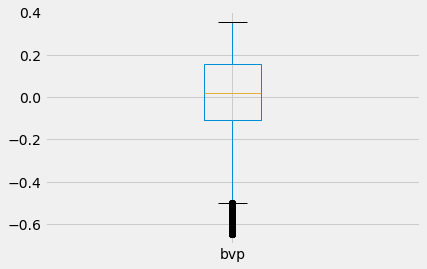

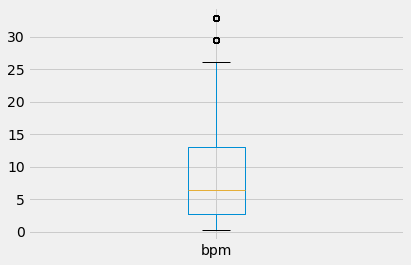

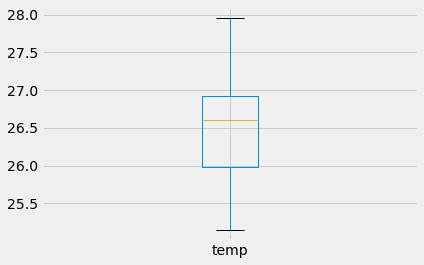

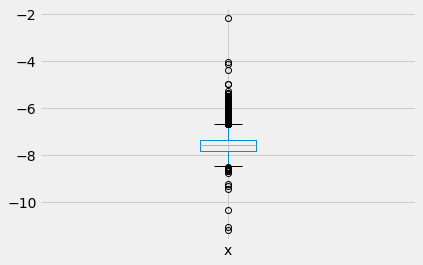

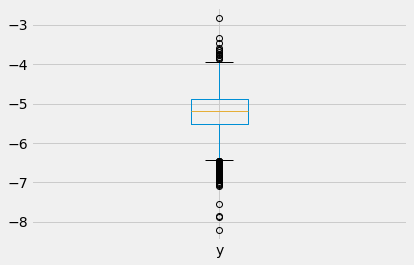

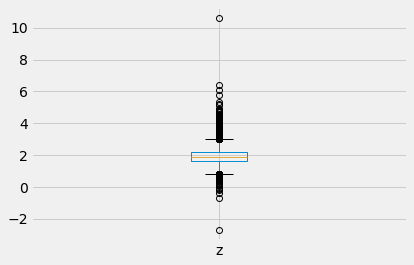

<Figure size 432x288 with 0 Axes>

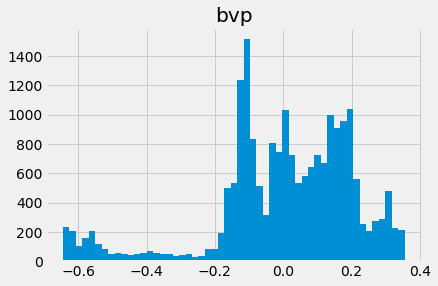

<Figure size 432x288 with 0 Axes>

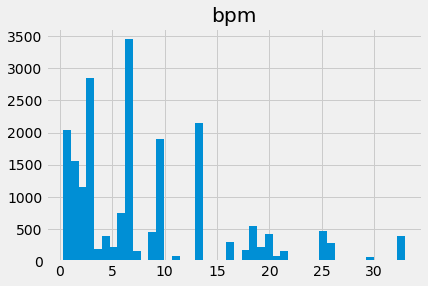

<Figure size 432x288 with 0 Axes>

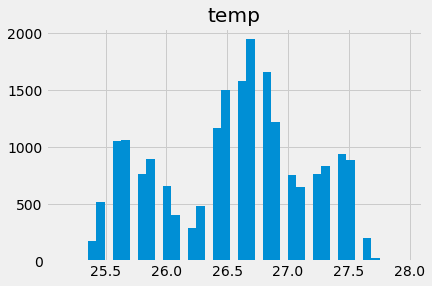

<Figure size 432x288 with 0 Axes>

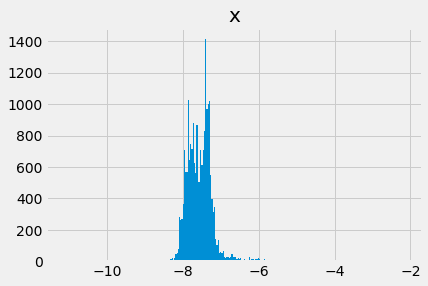

<Figure size 432x288 with 0 Axes>

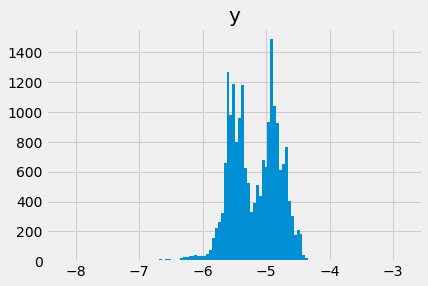

<Figure size 432x288 with 0 Axes>

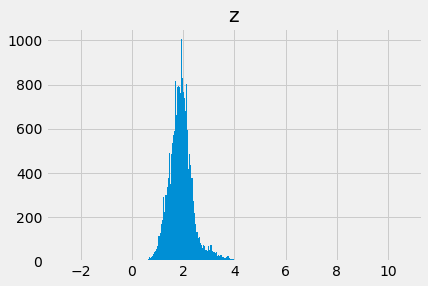

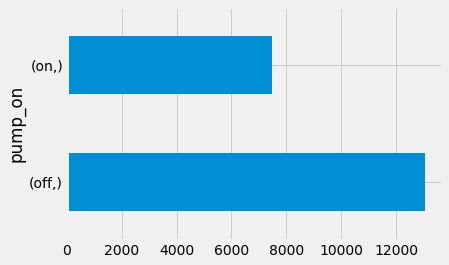

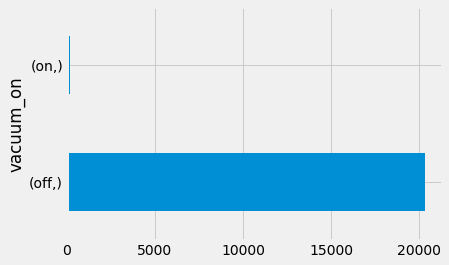

<Figure size 432x288 with 0 Axes>

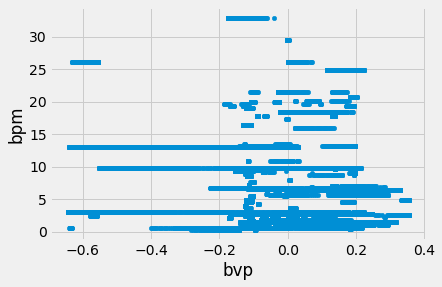

<Figure size 432x288 with 0 Axes>

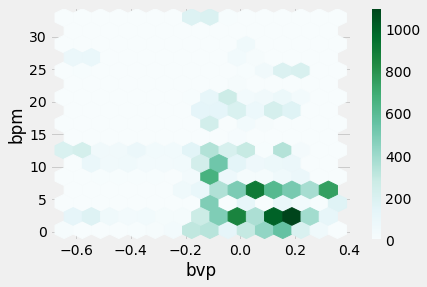

<Figure size 432x288 with 0 Axes>

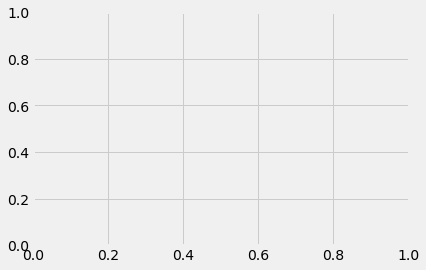

In [30]:
###########
## Plots ##
###########

"""
TO DO
- if it isn't a big overhead, remove the unnecessary graph pairs from the loop at the bottom, but it's not the end of the world to sort through at the end if you need to
- some down-sampling might have to occur so that the graphs are easier to interpret
- see if you can check if these images are already saved? so that you don't have to regenerate and save every time if you don't have to
- is there a way to make it so it saves but doesn't display? there's some stack error because there's too many graphs shown at once
"""

## Boxplots for each column
for column in continuous_cols:
    figure = plt.figure()
    boxplot = continuous_cols[[column]].boxplot()
    figure.savefig("plots/" + PARTICIPANT + "_boxplot_" + column + ".svg", format="svg")

## Histograms for each column
for column in continuous_cols:
    ## Calculate Freedman-Diaconis bin size
    q25 = continuous_cols[column].quantile(0.25)
    q75 = continuous_cols[column].quantile(0.75)
    max = continuous_cols[column].max()
    min = continuous_cols[column].min()
    num = len(continuous_cols)
    bin_width = (2*(q75 - q25)) /(num**(1/3))
    num_bins = math.ceil((max - min) / bin_width)

    ## Plot with the bin size determined above as num_bins
    figure = plt.figure()
    hist = continuous_cols[[column]].hist(bins=num_bins)
    figure.savefig("plots/" + PARTICIPANT + "_hist_" + column + ".svg", format="svg")

## Bar graphs for each column
for column in categorical_cols:
    figure = plt.figure()
    bar_graph = categorical_cols[[column]].value_counts().plot(kind="barh")
    figure.savefig("plots/" + PARTICIPANT + "_bar_" + column + ".svg", format="svg")

if 'vacuum_on' in data.columns:
    data = data.drop(columns = ['vacuum_on'])  # this one doesn't seem like it would influence? I guess I could keep it but it's not consistent across participants

for column in data:
    for column_2 in data:
        if column != column_2:
            ## need to do some downsampling or something here
            ## lots of unnecessary pairs but didn't seem work the time to get the distinct pairs
            figure1 = plt.figure()
            data.plot(x=column, y=column_2, kind = "scatter")
            figure.savefig("plots/bivariate/" + PARTICIPANT + "_" + column + "_" + column_2 + "_scatter.svg", format='svg')

            figure_2 = plt.figure()
            data.plot(x=column, y=column_2, kind = "hexbin", gridsize=15)
            figure_2.savefig("plots/bivariate/" + PARTICIPANT + "_" + column + "_" + column_2 + "_hexbin.svg", format='svg')

In [ ]:
##################################
## Functions for Classification ##
##################################

"""
TO DO
- a couple other classification techniques to compare
- graph predictions?
- svm
- naive bayes
- try something else too?
- check where I did normalization and if I actually have to do it, if so, normalize train and test separately
- drop first 5% and last 5% as outliers
    - this means that you can take out the fill nan for the first 9 that get weird because of the label smoothing
"""

def general_metrics(true_labels, predicted_labels):

    tn, fp, fn, tp = confusion_matrix(true_labels, predicted_labels).ravel()
    print("True Negative: {}".format(tn))
    print("False Positive: {}".format(fp))
    print("False Negative: {}".format(fn))
    print("True Positive: {}".format(tp))

    mse = mean_squared_error(y_true=true_labels,
                             y_pred=predicted_labels)
    print('\nMeans Squared Error: {}'.format(mse))

    mae = mean_absolute_error(y_true=true_labels,
                              y_pred=predicted_labels)
    print('\nMean Absolute Error: {}'.format(mae))

    f1 = f1_score(true_labels, predicted_labels, average=None)
    print('\nF1 Score: {}'.format(f1))

    precision = tp / (tp + fp)
    print("\nPrecision: {}".format(precision))

    recall = tp / (tp + fn)
    print("\nRecall: {} ".format(recall))

    accuracy = (tp + tn) / (tp + fp + tn + fn)
    print("\nAccuracy: {}\n ".format(accuracy))

    return


def xgboost(x_train, y_train, x_test, y_test, file_name):
    ## Create the model
    reg = xgb.XGBClassifier(n_estimators=1000)

    ## Fit the model
    reg.fit(x_train, y_train.values.ravel(),
            eval_set = [(x_train, y_train.values.ravel()), (x_test, y_test.values.ravel())],
            early_stopping_rounds = 50,
            verbose = False)

    ## Predict values from test features
    y_pred = reg.predict(x_test)

    ## Save the trained model for later
    reg.save_model(file_name)

    return y_pred


def logistic_regression(x_train, y_train, x_test, file_name):
    ## Create the model
    log_reg = LogisticRegression(solver='lbfgs', max_iter=1000)

    ## Fit the model
    log_reg.fit(x_train, y_train.values.ravel())

    ## Predict values from test features
    y_pred = log_reg.predict(x_test)

    ## Save the trained model for later
    #log_reg.save_model(file_name)

    return y_pred

def support_vector(x_train, y_train, x_test, y_test, file_name):
    ## Create the model
    svclassifier = SVC(kernel='linear')

    ## Fit the model
    svclassifier.fit(x_train, y_train.values.ravel())

    ## Predict values from test features
    y_pred = svclassifier.predict(x_test)

    ## Save the trained model for later
    #svclassifier.save_model(file_name)

    return y_pred

In [34]:
########################################
## Classifiers with Train Test Splits ##
########################################

## Prepare the data and split into features and labels
data = data.dropna()
y = data[['pump_on']]
y = y.replace({0.0: int(0), 1.0: int(1), 'off': int(0), 'on': int(1)})
x = data[["bvp", "bpm", "temp", "x", "y", "z"]]

## For every split in the listed train test splits, train different models
for size in TEST_SIZES:
    print("Training with test set size: {}".format(size))
    ## Split into training and testing
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = size, shuffle = False)
    ## This is where you would normalize if you want to, would be done independent of each other and only features, not labels
    
    ## XGBoost with this train/test split
    file_name_1 = "models/xgboost/" + PARTICIPANT + "_test_size_" + str(size)
    print("\n\nXGBoost\n")
    predictions_1 = xgboost(x_train, y_train, x_test, y_test, file_name_1)
    general_metrics(y_test, predictions_1)

    ## Logistic Regression with this train/test split
    file_name_2= "models/logistic_regression/" + PARTICIPANT + "_test_size_" + str(size)
    print("\n\nLogistic Regression\n")
    predictions_2 = logistic_regression(x_train, y_train, x_test, file_name_2)
    general_metrics(y_test, predictions_2)

    ## Logistic Regression with this train/test split
    file_name_3= "models/svm/" + PARTICIPANT + "_test_size_" + str(size)
    print("\n\nSVM\n")
    predictions_3 = support_vector(x_train, y_train, x_test, y_test, file_name_3)
    general_metrics(y_test, predictions_3)


Training with test set size: 0.1


XGBoost

[12:05:20] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/victoriaarmstrong/PycharmProjects/data_analysis/venv/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/victoriaarmstrong/PycharmProjects/data_analysis/venv/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


True Negative: 2017
False Positive: 33
False Negative: 0
True Positive: 0

Means Squared Error: 0.016097560975609757

Mean Absolute Error: 0.016097560975609757

F1 Score: [0.99188591 0.        ]

Precision: 0.0

Recall: nan 

Accuracy: 0.9839024390243902
 


Logistic Regression

True Negative: 2006
False Positive: 44
False Negative: 0
True Positive: 0

Means Squared Error: 0.021463414634146343

Mean Absolute Error: 0.021463414634146343

F1 Score: [0.98915187 0.        ]

Precision: 0.0

Recall: nan 

Accuracy: 0.9785365853658536
 


SVM



/home/victoriaarmstrong/PycharmProjects/data_analysis/venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


True Negative: 2007
False Positive: 43
False Negative: 0
True Positive: 0

Means Squared Error: 0.020975609756097562

Mean Absolute Error: 0.020975609756097562

F1 Score: [0.98940104 0.        ]

Precision: 0.0

Recall: nan 

Accuracy: 0.9790243902439024
 
Training with test set size: 0.2


XGBoost

[12:05:31] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/victoriaarmstrong/PycharmProjects/data_analysis/venv/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/victoriaarmstrong/PycharmProjects/data_analysis/venv/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


True Negative: 2751
False Positive: 998
False Negative: 0
True Positive: 351

Means Squared Error: 0.24341463414634146

Mean Absolute Error: 0.24341463414634146

F1 Score: [0.84646154 0.41294118]

Precision: 0.2601927353595256

Recall: 1.0 

Accuracy: 0.7565853658536585
 


Logistic Regression

True Negative: 2590
False Positive: 1159
False Negative: 7
True Positive: 344

Means Squared Error: 0.284390243902439

Mean Absolute Error: 0.284390243902439

F1 Score: [0.81626221 0.37108954]

Precision: 0.22887558216899534

Recall: 0.98005698005698 

Accuracy: 0.715609756097561
 


SVM



/home/victoriaarmstrong/PycharmProjects/data_analysis/venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


True Negative: 2607
False Positive: 1142
False Negative: 9
True Positive: 342

Means Squared Error: 0.2807317073170732

Mean Absolute Error: 0.2807317073170732

F1 Score: [0.81916732 0.37275204]

Precision: 0.23045822102425875

Recall: 0.9743589743589743 

Accuracy: 0.7192682926829268
 
Training with test set size: 0.3


XGBoost

[12:05:41] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/victoriaarmstrong/PycharmProjects/data_analysis/venv/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/victoriaarmstrong/PycharmProjects/data_analysis/venv/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


True Negative: 3268
False Positive: 980
False Negative: 124
True Positive: 1777

Means Squared Error: 0.17954138884371443

Mean Absolute Error: 0.17954138884371443

F1 Score: [0.85549738 0.76298841]

Precision: 0.6445411679361625

Recall: 0.9347711730668069 

Accuracy: 0.8204586111562856
 


Logistic Regression

True Negative: 3137
False Positive: 1111
False Negative: 58
True Positive: 1843

Means Squared Error: 0.19011221336802733

Mean Absolute Error: 0.19011221336802733

F1 Score: [0.84293967 0.7592173 ]

Precision: 0.6238997968855788

Recall: 0.9694897422409259 

Accuracy: 0.8098877866319727
 


SVM

True Negative: 3146
False Positive: 1102
False Negative: 70
True Positive: 1831

Means Squared Error: 0.19060009757684176

Mean Absolute Error: 0.19060009757684176

F1 Score: [0.84297964 0.75755068]

Precision: 0.6242754858506648

Recall: 0.9631772751183587 

Accuracy: 0.8093999024231583
 
Training with test set size: 0.4


XGBoost

[12:05:52] WARNING: ../src/learner.cc:1115: Starting 

/home/victoriaarmstrong/PycharmProjects/data_analysis/venv/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/victoriaarmstrong/PycharmProjects/data_analysis/venv/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


True Negative: 4219
False Positive: 29
False Negative: 3259
True Positive: 692

Means Squared Error: 0.4010245151847786

Mean Absolute Error: 0.4010245151847786

F1 Score: [0.71959748 0.29623288]

Precision: 0.9597780859916782

Recall: 0.17514553277651226 

Accuracy: 0.5989754848152213
 


Logistic Regression

True Negative: 3506
False Positive: 742
False Negative: 986
True Positive: 2965

Means Squared Error: 0.21075740944017562

Mean Absolute Error: 0.21075740944017562

F1 Score: [0.80228833 0.77435362]

Precision: 0.7998381440517939

Recall: 0.7504429258415591 

Accuracy: 0.7892425905598244
 


SVM

True Negative: 3562
False Positive: 686
False Negative: 1132
True Positive: 2819

Means Squared Error: 0.2217343578485181

Mean Absolute Error: 0.2217343578485181

F1 Score: [0.79668978 0.75616953]

Precision: 0.8042796005706134

Recall: 0.7134902556314857 

Accuracy: 0.7782656421514819
 
Training with test set size: 0.5


XGBoost

[12:05:57] WARNING: ../src/learner.cc:1115: Starting in 

/home/victoriaarmstrong/PycharmProjects/data_analysis/venv/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/victoriaarmstrong/PycharmProjects/data_analysis/venv/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/victoriaarmstrong/PycharmProjects/data_analysis/venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (stat

True Negative: 4111
False Positive: 2038
False Negative: 351
True Positive: 3748

Means Squared Error: 0.23311865729898518

Mean Absolute Error: 0.23311865729898518

F1 Score: [0.77485628 0.75832069]

Precision: 0.6477704804701002

Recall: 0.9143693583800927 

Accuracy: 0.7668813427010148
 


SVM

True Negative: 4543
False Positive: 1606
False Negative: 557
True Positive: 3542

Means Squared Error: 0.21106557377049182

Mean Absolute Error: 0.21106557377049182

F1 Score: [0.80771624 0.7660863 ]

Precision: 0.688034188034188

Recall: 0.8641131983410588 

Accuracy: 0.7889344262295082
 
Training with test set size: 0.6


XGBoost

[12:06:01] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
True Negative: 2388
False Positive: 5579
False Negative: 779
True Positive: 3552

Means Squared Error: 0.516994633

/home/victoriaarmstrong/PycharmProjects/data_analysis/venv/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/victoriaarmstrong/PycharmProjects/data_analysis/venv/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/victoriaarmstrong/PycharmProjects/data_analysis/venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (stat

True Negative: 25
False Positive: 7942
False Negative: 24
True Positive: 4307

Means Squared Error: 0.6477476012359733

Mean Absolute Error: 0.6477476012359733

F1 Score: [0.00623752 0.51954162]

Precision: 0.3516205404522818

Recall: 0.9944585546063265 

Accuracy: 0.3522523987640267
 
Training with test set size: 0.7


XGBoost

[12:06:01] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
True Negative: 7941
False Positive: 26
False Negative: 5216
True Positive: 1165

Means Squared Error: 0.36534708670197935

Mean Absolute Error: 0.36534708670197935

F1 Score: [0.75184624 0.30771263]

Precision: 0.9781696053736356

Recall: 0.18257326437862403 

Accuracy: 0.6346529132980206
 


Logistic Regression

True Negative: 231
False Positive: 7736
False Negative: 118
True Positive: 6263

Means Squared Error: 

/home/victoriaarmstrong/PycharmProjects/data_analysis/venv/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/victoriaarmstrong/PycharmProjects/data_analysis/venv/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/victoriaarmstrong/PycharmProjects/data_analysis/venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (stat

True Negative: 212
False Positive: 7755
False Negative: 117
True Positive: 6264

Means Squared Error: 0.5486478951770282

Mean Absolute Error: 0.5486478951770282

F1 Score: [0.05110897 0.61411765]

Precision: 0.4468221699122619

Recall: 0.9816643159379408 

Accuracy: 0.45135210482297183
 
Training with test set size: 0.8


XGBoost



/home/victoriaarmstrong/PycharmProjects/data_analysis/venv/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/victoriaarmstrong/PycharmProjects/data_analysis/venv/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


ValueError: y contains previously unseen labels: [1]